<a href="https://colab.research.google.com/github/ArinaLazarenko/Out-of-Distribution-Detection/blob/main/ood_detection_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Loading

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define transformations (normalize images to match ImageNet mean and std)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the model's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
loader_cifar10 = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified


In [2]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch

# Load processor and model
processor = AutoImageProcessor.from_pretrained("aaraki/vit-base-patch16-224-in21k-finetuned-cifar10")
model = AutoModelForImageClassification.from_pretrained("aaraki/vit-base-patch16-224-in21k-finetuned-cifar10")

# Set model to evaluation mode
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

# Accuracy Check

In [ ]:
from torch.nn.functional import softmax
from tqdm import tqdm

def compute_accuracy(model, dataloader):
    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            predictions = torch.argmax(outputs.logits, dim=1)

            # Update correct and total counts
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    return accuracy

In [ ]:
accuracy_cifar10 = compute_accuracy(model, loader_cifar10)
print(f"Accuracy on CIFAR-10 test set: {accuracy_cifar10:.2f}%")

100%|██████████| 313/313 [00:35<00:00,  8.71it/s]

Accuracy on CIFAR-10 test set: 95.12%


In [11]:
# Load CIFAR-100 test set
testset_cifar100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
loader_cifar100 = torch.utils.data.DataLoader(testset_cifar100, batch_size=32, shuffle=False)

100%|██████████| 169M/169M [00:12<00:00, 13.0MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


In [ ]:
accuracy_cifar100 = compute_accuracy(model, loader_cifar100)
print(f"Accuracy on CIFAR-100 test set: {accuracy_cifar100:.2f}%")

100%|██████████| 313/313 [00:34<00:00,  9.01it/s]

Accuracy on CIFAR-100 test set: 0.97%


# Prediction samples

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.nn.functional import softmax

labels_cifar10 = testset.classes

def show_samples_with_predictions(model, dataloader, labels_cifar, num_samples=5):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Collect all images and labels from the dataloader
    all_images, all_labels = [], []
    for images, labels in dataloader:
        all_images.append(images)
        all_labels.append(labels)

    # Concatenate to form a single dataset
    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)

    # Select random indices
    total_samples = len(all_images)
    random_indices = random.sample(range(total_samples), num_samples)

    # Get random images and labels
    images = all_images[random_indices].to(device)
    labels = all_labels[random_indices].to(device)

    with torch.no_grad():
        outputs = model(images)
        predictions = torch.argmax(outputs.logits, dim=1)

    # Plot the images and predictions
    images = images.cpu().numpy().transpose((0, 2, 3, 1))  # Rearrange dimensions for plotting
    images = np.clip(images * 0.229 + 0.485, 0, 1)  # Unnormalize images

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f"Pred: {labels_cifar10[predictions[i]]}\nTrue: {labels_cifar[labels[i]]}")
        plt.axis('off')
    plt.show()

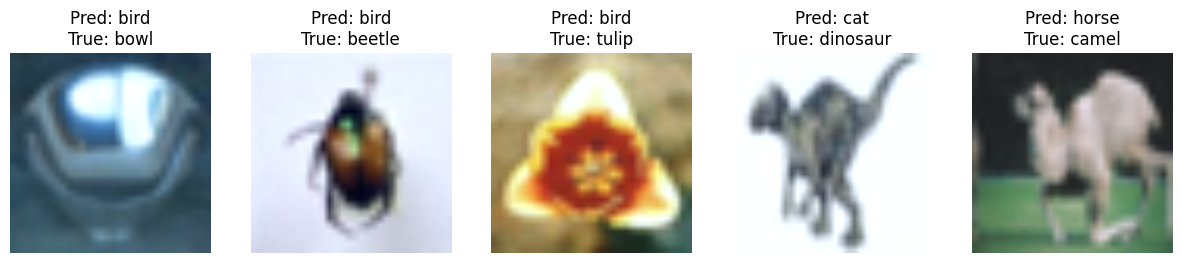

In [17]:
labels_cifar100 = testset_cifar100.classes
show_samples_with_predictions(model, loader_cifar100, labels_cifar100, num_samples=5)

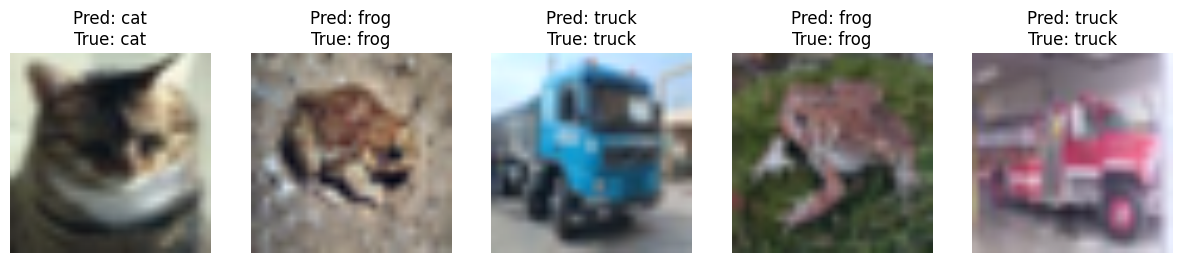

In [18]:
labels_cifar10 = testset.classes
show_samples_with_predictions(model, loader_cifar10, labels_cifar10, num_samples=5)

# Softmax Scores Calculation

In [ ]:
!pip install scikit-learn

In [48]:
from torch.nn.functional import softmax
from tqdm import tqdm

def get_softmax_scores(model, dataloader, num_samples=None):
    """Compute softmax max probabilities for a given dataset."""
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    softmax_scores = []
    softmax_labels = []
    true_false_labels = []

    # Remove this line, as it overwrites the softmax function
    # softmax = torch.nn.Softmax(dim=1)

    with torch.no_grad():
        for i, (images, true_labels) in enumerate(dataloader):  # true_labels is provided by the dataloader
            if num_samples and i * dataloader.batch_size >= num_samples:
                break

            images = images.to(device)
            true_labels = true_labels.to(device)  # Move true labels to the same device as images

            outputs = model(images)
            # Use torch.nn.functional.softmax directly, and pass dim as an argument
            probs = softmax(outputs.logits, dim=1)

            # Get the maximum probability for each sample (confidence score)
            max_probs, max_indices = torch.max(probs, dim=1)
            softmax_scores.extend(max_probs.cpu().numpy())
            softmax_labels.extend(max_indices.cpu().numpy())

            # Check if the predictions are correct and append 1 for correct, 0 for incorrect
            correct_predictions = (max_indices == true_labels).cpu().numpy().astype(int)
            true_false_labels.extend(correct_predictions)

    return np.array(softmax_scores), softmax_labels, true_false_labels

In [49]:
# Collect softmax scores for CIFAR-10 (in-distribution)
softmax_scores_cifar10, softmax_labels_cifar10, true_false_labels_cifar10 = get_softmax_scores(model, loader_cifar10)

In [50]:
# Print the first 10 softmax scores for CIFAR-10
print("Softmax scores (CIFAR-10, in-distribution):")
print(softmax_scores_cifar10[:10])

Softmax scores (CIFAR-10, in-distribution):
[0.8125812  0.757679   0.58414805 0.7105681  0.8389872  0.81933576
 0.595594   0.81367284 0.8112129  0.771013  ]


In [51]:
print("Softmax labels (CIFAR-10, in-distribution):")
print(softmax_labels_cifar10[:10])

Softmax labels (CIFAR-10, in-distribution):
[3, 8, 8, 0, 6, 6, 1, 6, 3, 1]


In [52]:
softmax_labels_names_n = [labels_cifar10[i] for i in softmax_labels_cifar10[:10]]
print(softmax_labels_names_n)

['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile']


In [64]:
print("true / false values (CIFAR-10, in-distribution):")
print(true_false_labels_cifar10[:30])

true / false values (CIFAR-10, in-distribution):
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


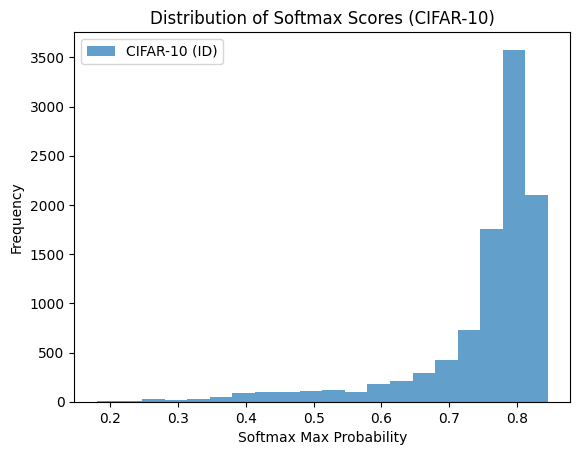

In [39]:
import matplotlib.pyplot as plt

plt.hist(softmax_scores_cifar10, bins=20, alpha=0.7, label='CIFAR-10 (ID)')
plt.xlabel('Softmax Max Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Softmax Scores (CIFAR-10)')
plt.legend()
plt.show()

In [57]:
# Collect softmax scores for CIFAR-100 (out-of-distribution)
softmax_scores_cifar100, softmax_labels_cifar100, true_false_labels_cifar100 = get_softmax_scores(model, loader_cifar100)
true_false_labels_cifar100 = [0] * len(true_false_labels_cifar100)

In [58]:
# Print the first 10 softmax scores for CIFAR-10
print("Softmax scores (CIFAR-100, out-of-distribution):")
print(softmax_scores_cifar100[:10])

Softmax scores (CIFAR-100, out-of-distribution):
[0.71583414 0.3191128  0.45257974 0.5382675  0.18522757 0.19882798
 0.58180046 0.60236335 0.3374849  0.23093158]


In [59]:
print("Softmax labels (CIFAR-100, out-of-distribution):")
print(softmax_labels_cifar100[:10])

Softmax labels (CIFAR-100, out-of-distribution):
[8, 2, 2, 2, 0, 2, 2, 3, 0, 2]


In [60]:
softmax_labels_names_n = [labels_cifar100[i] for i in softmax_labels_cifar100[:10]]
print(softmax_labels_names_n)

['bicycle', 'baby', 'baby', 'baby', 'apple', 'baby', 'baby', 'bear', 'apple', 'baby']


In [63]:
print("true / false values (CIFAR-100, out-of-distribution):")
print(true_false_labels_cifar100[:30])

true / false values (CIFAR-100, out-of-distribution):
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


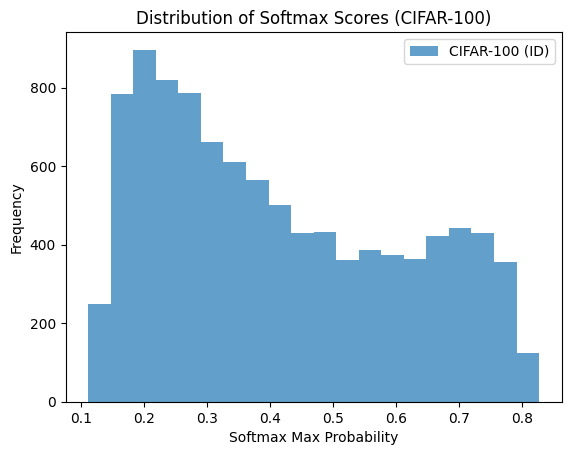

In [25]:
plt.hist(softmax_scores_cifar100, bins=20, alpha=0.7, label='CIFAR-100 (ID)')
plt.xlabel('Softmax Max Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Softmax Scores (CIFAR-100)')
plt.legend()
plt.show()

# Threshold Calculation

In [73]:
# softmax_scores_cifar10
# softmax_scores_cifar100
# softmax_labels_cifar10
# softmax_labels_cifar100
# true_false_labels_cifar10
# true_false_labels_cifar100

true_positive = []
false_positive = []

false_positive.extend(softmax_scores_cifar100)

for i in range(len(true_false_labels_cifar10)):
    if true_false_labels_cifar10[i] == 0:
        false_positive.append(softmax_scores_cifar10[i])
    else:  # If it's 1
        true_positive.append(softmax_scores_cifar10[i])

In [74]:
print(len(true_positive))
print(len(false_positive))

9512
10488


In [75]:
print(true_positive[:30])

[0.8125812, 0.757679, 0.58414805, 0.7105681, 0.8389872, 0.81933576, 0.595594, 0.81367284, 0.8112129, 0.771013, 0.8075013, 0.80637485, 0.7571642, 0.76158506, 0.8101111, 0.823132, 0.7413641, 0.81203806, 0.76092243, 0.80568326, 0.80397165, 0.6369237, 0.7830908, 0.7703241, 0.6166887, 0.7397498, 0.80643284, 0.8148272, 0.78330624, 0.82474375]


In [76]:
print(false_positive[:30])

[0.71583414, 0.3191128, 0.45257974, 0.5382675, 0.18522757, 0.19882798, 0.58180046, 0.60236335, 0.3374849, 0.23093158, 0.3789747, 0.6755776, 0.73948675, 0.38922003, 0.2668581, 0.60486704, 0.16678244, 0.70779973, 0.16234708, 0.19249061, 0.1940219, 0.3783868, 0.61226654, 0.3397702, 0.32753628, 0.24088378, 0.12043789, 0.1662893, 0.1462454, 0.34039664]


In [79]:
# Calculate average for true_positive
avg_true_positive = sum(true_positive) / len(true_positive) if len(true_positive) > 0 else 0

# Calculate average for false_positive
avg_false_positive = sum(false_positive) / len(false_positive) if len(false_positive) > 0 else 0

print(f"Average True Positive: {avg_true_positive}")
print(f"Average False Positive: {avg_false_positive}")

Average True Positive: 0.7622425932581305
Average False Positive: 0.4191011396541475


In [82]:
threshold = (avg_true_positive + avg_false_positive) / 2
print(f"Threshold: {threshold:.2f}")

OOD border: 0.59


# AUROC Calculation

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# 1. Create a combined list of true labels and scores for AUROC
auroc_labels = []
auroc_scores = []

# CIFAR-10: in-distribution
for i in range(len(softmax_scores_cifar10)):
    auroc_labels.append(1)  # CIFAR-10 is in-distribution (ID)
    correct = int(true_false_labels_cifar10[i] == 1)  # True if predicted correctly
    auroc_scores.append(correct)  # 1 for correct, 0 for incorrect

# CIFAR-100: out-of-distribution
for i in range(len(softmax_scores_cifar100)):
    auroc_labels.append(0)  # CIFAR-100 is out-of-distribution (OOD)
    correct = int(not (softmax_scores_cifar100[i] < 0.59))  # Correct if score < 0.59 (OOD correctly detected)
    auroc_scores.append(correct)  # 1 for correct, 0 for incorrect

AUROC: 0.8574


In [85]:
print(auroc_labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [92]:
print(auroc_scores)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [95]:
true_count = 0
false_count = 0

# Assuming auroc_labels and auroc_scores are lists with the same length
for i in range(len(auroc_labels)):
    if auroc_labels[i] == auroc_scores[i]:
        true_count += 1  # Increment true_count if label and score match
    else:
        false_count += 1  # Increment false_count if label and score do not match

# Output the results
print(f"True count: {true_count}")
print(f"False count: {false_count}")

True count: 17147
False count: 2853


In [96]:
auroc = roc_auc_score(auroc_labels, auroc_scores)
print(f"AUROC: {auroc:.4f}")

AUROC: 0.8574


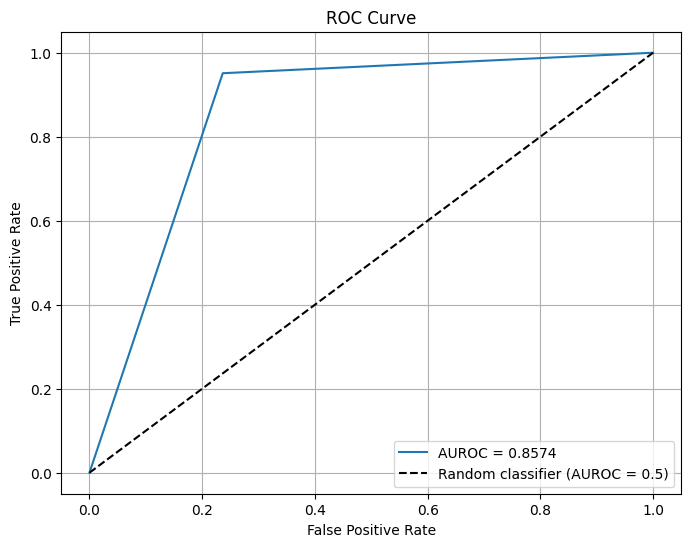

AUROC Score: 0.8574


In [98]:
from sklearn.metrics import roc_curve, auc

# Convert lists to numpy arrays for compatibility with sklearn
auroc_labels = np.array(auroc_labels)
auroc_scores = np.array(auroc_scores)

# Calculate ROC curve values
fpr, tpr, thresholds = roc_curve(auroc_labels, auroc_scores)

# Calculate AUROC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUROC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier (AUROC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the AUROC score
print(f"AUROC Score: {roc_auc:.4f}")



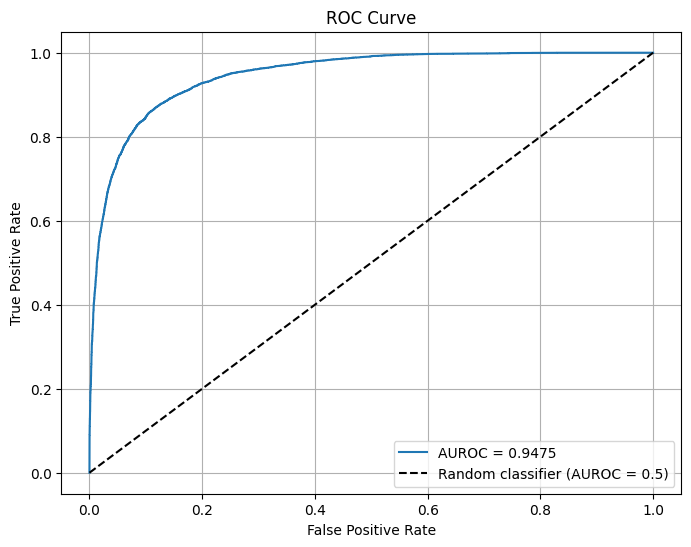

AUROC Score: 0.9475


In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Create the labels: 1 for true positives, 0 for false positives
total_auroc_labels = np.concatenate([np.ones(len(true_positive)), np.zeros(len(false_positive))])

# Combine both true and false positive probabilities
scores = np.concatenate([true_positive, false_positive])

# Compute AUROC score
auroc_score = roc_auc_score(total_auroc_labels, scores)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(total_auroc_labels, scores)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUROC = {auroc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier (AUROC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the AUROC score
print(f"AUROC Score: {auroc_score:.4f}")


# OOD Detection

In [111]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

def show_samples_with_predictions_ood(model, dataloader, labels_cifar, num_samples=5, threshold=0.59):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Collect all images and labels from the dataloader
    all_images, all_labels = [], []
    for images, labels in dataloader:
        all_images.append(images)
        all_labels.append(labels)

    # Concatenate to form a single dataset
    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)

    # Select random indices
    total_samples = len(all_images)
    random_indices = random.sample(range(total_samples), num_samples)

    # Get random images and labels
    images = all_images[random_indices].to(device)
    labels = all_labels[random_indices].to(device)

    with torch.no_grad():
        outputs = model(images)
        softmax_scores = torch.softmax(outputs.logits, dim=1)
        max_scores, predictions = torch.max(softmax_scores, dim=1)

    # Determine if the predictions are OOD or not
    is_ood = max_scores < threshold  # OOD if the maximum score is lower than the threshold

    # Plot the images, predictions, and OOD labels
    images = images.cpu().numpy().transpose((0, 2, 3, 1))  # Rearrange dimensions for plotting
    images = np.clip(images * 0.229 + 0.485, 0, 1)  # Unnormalize images

    rows = (num_samples + 4) // 5  # This ensures at least 1 row for 5 images

    plt.figure(figsize=(15, 5 * rows))
    for i in range(num_samples):
        row = i // 5
        col = i % 5
        plt.subplot(rows, 5, i + 1)
        plt.imshow(images[i])

        # Display OOD label if applicable, including the prediction score
        if is_ood[i]:
            plt.title(f"Pred: OOD\nTrue: {labels_cifar[labels[i]]}\nScore: {max_scores[i]:.3f}")
        else:
            plt.title(f"Pred: {labels_cifar10[predictions[i]]}\nTrue: {labels_cifar[labels[i]]}\nScore: {max_scores[i]:.3f}")

        plt.axis('off')

    plt.show()

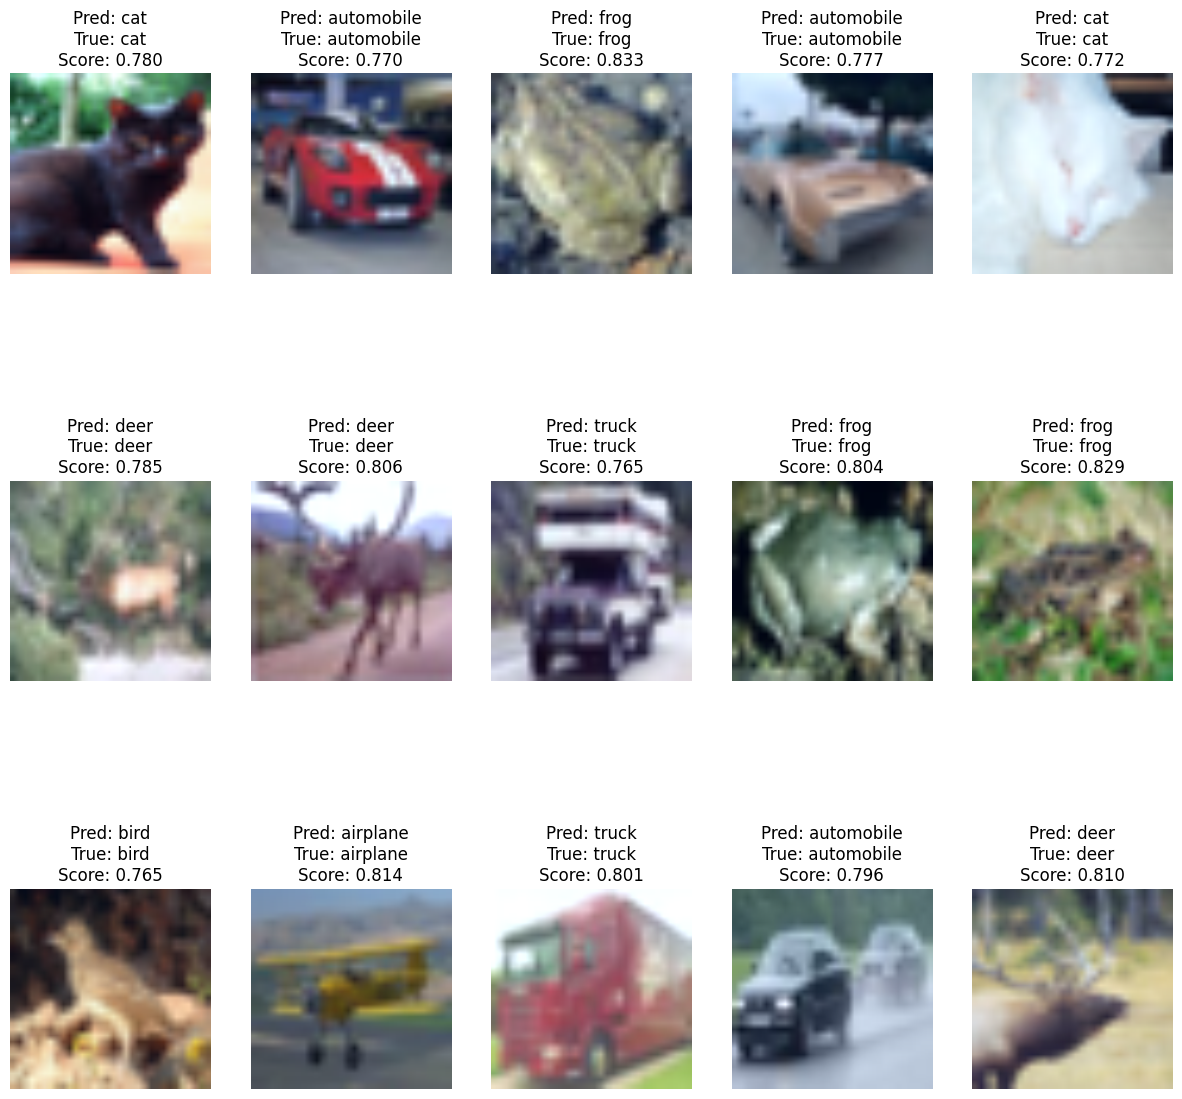

In [113]:
show_samples_with_predictions_ood(model, loader_cifar10, labels_cifar10, num_samples=15)

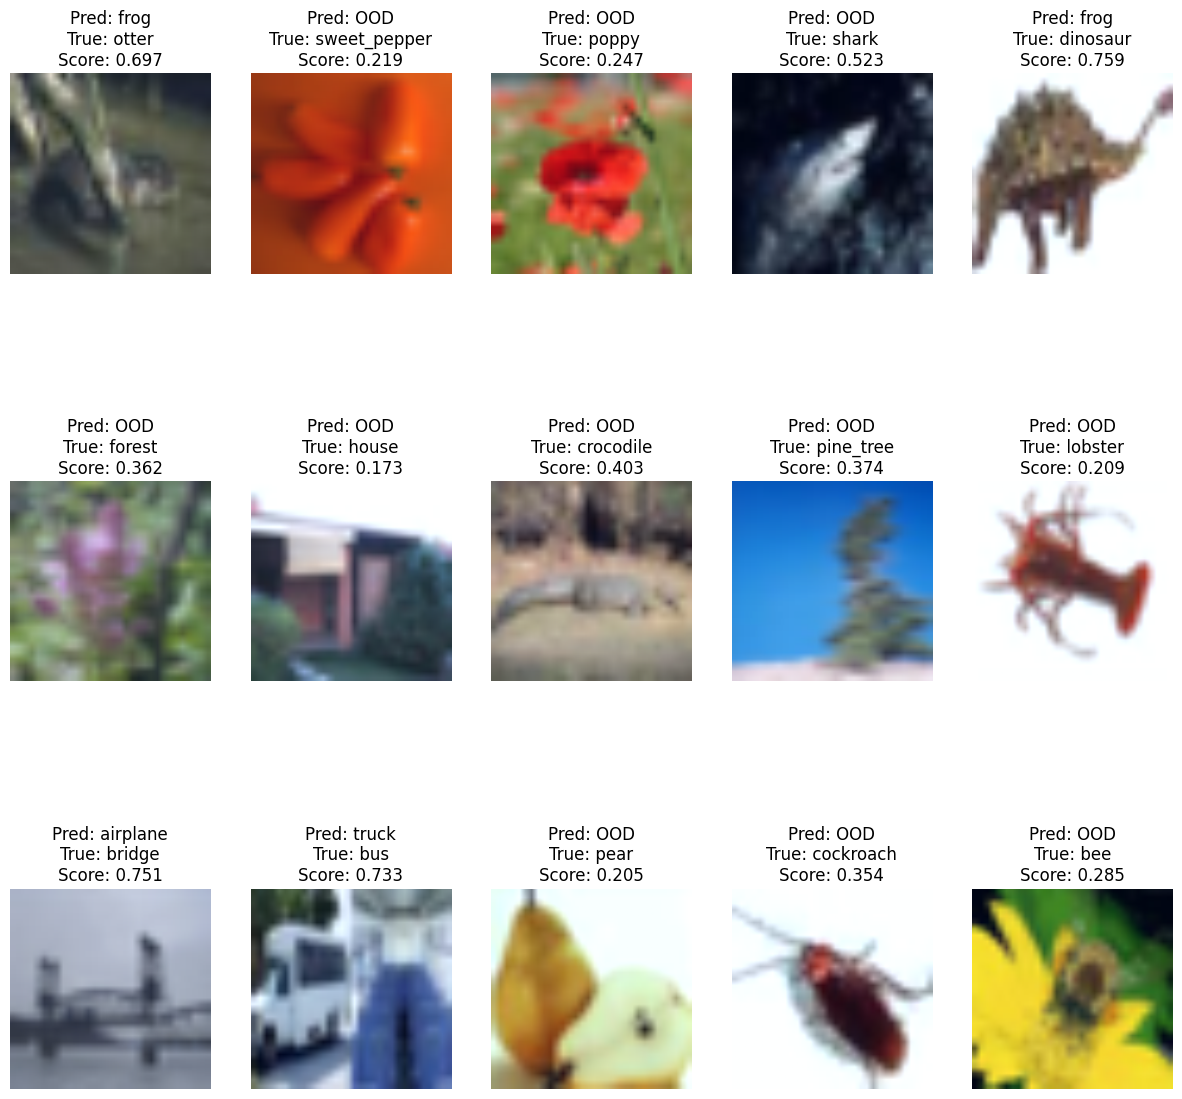

In [112]:
show_samples_with_predictions_ood(model, loader_cifar100, labels_cifar100, num_samples=15)